<a href="https://colab.research.google.com/github/paulxdillon/Chem-Eng/blob/master/tankLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test of tank level control

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
import pyomo.environ as pyo
import pyomo.gdp as gdp

Text(0.5, 1.0, 'Demand')

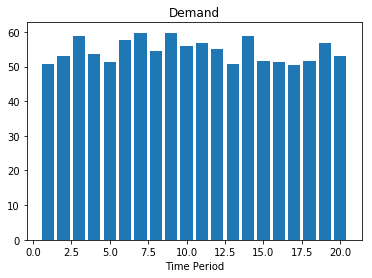

In [23]:
# demand
T = 20
T = np.array([t for t in range(0, T)])
d = np.array([50 + 10*np.random.uniform() for t in T])

fig, ax = plt.subplots(1,1)
ax.bar(T+1, d)
ax.set_xlabel('Time Period')
ax.set_title('Demand')

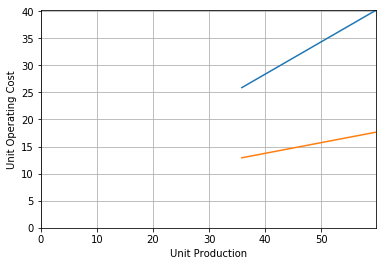

In [38]:
# generating units
N = 2
pmax = 2*max(d)/N
pmin = 0.6*pmax

N = np.array([n for n in range(0, N)])
a = np.array([0.5 + 0.2*np.random.randn() for n in N])
b = np.array([10*np.random.uniform() for n in N])

p = np.linspace(pmin, pmax)

fig, ax = plt.subplots(1,1)
for n in N:
    ax.plot(p, a[n]*p + b[n])
ax.set_xlim(0, pmax)
ax.set_ylim(0, max(a*pmax + b))
ax.set_xlabel('Unit Production')
ax.set_ylabel('Unit Operating Cost')
ax.grid()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 332.43091918
  Upper bound: 332.43091918
  Number of objectives: 1
  Number of constraints: 80
  Number of variables: 60
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 60
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Br

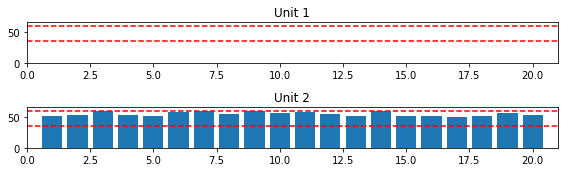

In [39]:
def unit_commitment():
    m = pyo.ConcreteModel()

    m.N = pyo.Set(initialize=N)
    m.T = pyo.Set(initialize=T)

    m.x = pyo.Var(m.N, m.T, bounds = (0, pmax))
    m.u = pyo.Var(m.N, m.T, domain=pyo.Binary)
    
    # objective
    m.cost = pyo.Objective(expr = sum(m.x[n,t]*a[n] + m.u[n,t]*b[n] for t in m.T for n in m.N), sense=pyo.minimize)
    
    # demand
    m.demand = pyo.Constraint(m.T, rule=lambda m, t: sum(m.x[n,t] for n in N) == d[t])
    
    # semi-continuous
    m.lb = pyo.Constraint(m.N, m.T, rule=lambda m, n, t: pmin*m.u[n,t] <= m.x[n,t])
    m.ub = pyo.Constraint(m.N, m.T, rule=lambda m, n, t: pmax*m.u[n,t] >= m.x[n,t])
    return m
   
m = unit_commitment()
pyo.SolverFactory('cbc').solve(m).write()

fig, ax = plt.subplots(max(N)+1, 1, figsize=(8, 1.5*max(N)+1))
for n in N:
    ax[n].bar(T+1, [m.x[n,t]() for t in T])
    ax[n].set_xlim(0, max(T)+2)
    ax[n].set_ylim(0, 1.1*pmax)
    ax[n].plot(ax[n].get_xlim(), np.array([pmax, pmax]), 'r--')
    ax[n].plot(ax[n].get_xlim(), np.array([pmin, pmin]), 'r--')
    ax[n].set_title('Unit ' + str(n+1))
fig.tight_layout()